# Expression Quality Control (Part 1)
This is a template notebook for performing preliminary quality control on your organism's expression data.

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from os import path

In [2]:
sns.set_style('ticks')

### Inputs

Enter path of log-TPM, MultiQC, and metadata files here

In [3]:
logTPM_file = path.join('..','data','raw_data','log_tpm.csv') # Enter log-TPM filename here
multiqc_file = path.join('..','data','raw_data','multiqc_stats.tsv') # Enter MultiQC stats filename here
metadata_file = path.join('..','data','raw_data','Zymomonas_mobilis.csv') # Enter metadata filename here

### Load expression data

In [4]:
DF_log_tpm = pd.read_csv(logTPM_file,index_col=0).fillna(0)
print('Number of genes:',DF_log_tpm.shape[0])
print('Number of samples:',DF_log_tpm.shape[1])
DF_log_tpm.head()

Number of genes: 1915
Number of samples: 423


,Kiley_A_DZM0422_Aerobic_A,Kiley_A_DZM0422_Aerobic_B,Kiley_A_DZM0422_Aerobic_C,Kiley_A_DZM0422_Anaerobic_A,Kiley_A_DZM0422_Anaerobic_B,Kiley_A_DZM0422_Anaerobic_C,Kiley_A_WT_Aerobic_A,Kiley_A_WT_Aerobic_B,Kiley_A_WT_Aerobic_C,Kiley_A_WT_Anaerobic_A,...,SRX8694720,SRX8694721,SRX8694722,SRX8694723,SRX8694724,SRX8694725,SRX8694726,SRX8694727,SRX8694728,SRX8694729
Geneid,,,,,,,,,,,,,,,,,,,,,
ZMO1_ZMO0001,7.033195,6.570070,6.707074,3.171341,3.033476,2.844070,6.653994,6.809693,6.682558,2.732789,...,1.753641,2.223487,2.052982,1.875120,2.188857,1.574801,1.669853,2.062012,2.138308,2.069756
ZMO1_ZMO0002,5.974006,5.457485,5.885887,3.366082,3.020571,3.336180,5.939219,6.013707,5.871256,3.017061,...,3.040491,3.920783,3.405044,2.882627,3.761746,3.233458,3.495415,3.388712,3.444051,3.200237
ZMO1_ZMO0003,8.531162,8.369203,8.503991,8.333806,8.178450,8.306738,8.792909,8.830305,8.689268,8.225090,...,6.293177,6.237941,6.232051,5.882153,5.814763,5.365343,8.503064,8.456684,8.463556,8.617567
ZMO1_ZMO0004,9.183870,8.962011,9.150824,8.838679,8.697385,8.829572,9.353565,9.490085,9.337280,8.681039,...,6.031110,6.760056,6.784884,5.901870,5.864879,5.969200,8.992431,8.773890,8.817081,8.879091
ZMO1_ZMO0005,9.233594,9.189375,9.186695,8.836405,8.686753,8.851473,9.270485,9.487119,9.374216,8.610282,...,6.095057,7.540109,7.648744,6.553449,6.502532,6.500744,9.995349,9.489807,9.294369,9.380150


### Load QC data
There may be some datasets that failed along the processing pipeline, so the number of samples with QC data may be higher than the number of samples with expression data.

In [5]:
DF_qc_stats = pd.read_csv(multiqc_file,index_col=0, sep='\t')
print('Number of samples with QC data:',DF_qc_stats.shape[0])

Number of samples with QC data: 423


In [6]:
DF_qc_stats.fillna(0,inplace=True)
DF_qc_stats.head()

,Unassigned_Unmapped,Unassigned_MultiMapping,percent_assigned,Unassigned_MappingQuality,Unassigned_NonSplit,Assigned,Total,Unassigned_FragmentLength,Unassigned_Duplicate,Unassigned_rRNA,...,r_written,percent_trimmed,bp_written,r_with_adapters,bp_processed,pe_sense,se_antisense,pe_antisense,failed,se_sense
Sample,,,,,,,,,,,,,,,,,,,,,
Kiley_A_DZM0422_Aerobic_A,2184498,0,77.764392,0,0,56316666,72419606,0,0,7522108,...,36247731,9.889658,4899443136,21176068,5437159650,0.0235,0.0,0.5349,0.4416,0.0
Kiley_A_DZM0422_Aerobic_B,1965794,0,79.402332,0,0,54552211,68703538,0,0,6090661,...,34391133,9.359970,4675819966,19801327,5158669950,0.0224,0.0,0.5395,0.4382,0.0
Kiley_A_DZM0422_Aerobic_C,2104834,0,78.714749,0,0,55045254,69930038,0,0,6646331,...,35013714,9.093504,4774461067,20280173,5252057100,0.0221,0.0,0.5401,0.4377,0.0
Kiley_A_DZM0422_Anaerobic_A,3295050,0,78.351455,0,0,58375783,74505040,0,0,6465873,...,37305687,9.003477,5092031721,21565339,5595853050,0.0209,0.0,0.5545,0.4245,0.0
Kiley_A_DZM0422_Anaerobic_B,2761952,0,78.440823,0,0,49423959,63007956,0,0,5262562,...,31539542,9.906758,4262249405,18920908,4730931300,0.0230,0.0,0.5522,0.4248,0.0


### Load metadata

In [7]:
DF_metadata = pd.read_csv(metadata_file,index_col=0, encoding='latin1')
print('Number of samples with metadata:',DF_metadata.shape[0])
DF_metadata.head()

Number of samples with metadata: 427


,BioProject,additional_details_2,sample_id,study,project,condition,rep_id,doi,gene_KO,Strain Description,...,skip,lab,Sequencing Machine,LibraryLayout,Platform,Biological Replicates,GEO,SRX,Run,run_date
energy_production_1,,,,,,,,,,,,,,,,,,,,,
SRX10341586,PRJNA714535,AF532_1,NaN,furfural_acetic_acid_stress,furfural_acetic_acid_stress,acid_ZM532,1,10.1186/s12934-023-02095-1,NaN,Zymomonas mobilis 532,...,NaN,Chinese Academy of Agricultural Science,Illumina HiSeq 2000,PAIRED,ILLUMINA,NaN,NaN,SRX10341586,SRR13963594,3/18/2021 4:56
SRX10341587,PRJNA714535,AF532_2,NaN,furfural_acetic_acid_stress,furfural_acetic_acid_stress,acid_ZM532,2,10.1186/s12934-023-02095-1,NaN,Zymomonas mobilis 532,...,NaN,Chinese Academy of Agricultural Science,Illumina HiSeq 2000,PAIRED,ILLUMINA,NaN,NaN,SRX10341587,SRR13963596,3/18/2021 4:56
SRX10341588,PRJNA714535,AF532_3,NaN,furfural_acetic_acid_stress,furfural_acetic_acid_stress,acid_ZM532,3,10.1186/s12934-023-02095-1,NaN,Zymomonas mobilis 532,...,NaN,Chinese Academy of Agricultural Science,Illumina HiSeq 2000,PAIRED,ILLUMINA,NaN,NaN,SRX10341588,SRR13963597,3/18/2021 4:56
SRX10341589,PRJNA714535,AFZM4_1,NaN,furfural_acetic_acid_stress,furfural_acetic_acid_stress,acid_ZM4,1,10.1186/s12934-023-02095-1,NaN,Zymomonas mobilis,...,NaN,Chinese Academy of Agricultural Science,Illumina HiSeq 2000,PAIRED,ILLUMINA,NaN,NaN,SRX10341589,SRR13963598,3/18/2021 4:56
SRX10341590,PRJNA714535,AFZM4_2,NaN,furfural_acetic_acid_stress,furfural_acetic_acid_stress,acid_ZM4,2,10.1186/s12934-023-02095-1,NaN,Zymomonas mobilis,...,NaN,Chinese Academy of Agricultural Science,Illumina HiSeq 2000,PAIRED,ILLUMINA,NaN,NaN,SRX10341590,SRR13963599,3/18/2021 4:56


### Remove extra sample rows

Ensure that metadata and qc_stats data contain all log_tpm sample information.

In [8]:
assert(set(DF_log_tpm.columns) - set(DF_metadata.index) == set())
assert(set(DF_log_tpm.columns) - set(DF_qc_stats.index) == set())

In [9]:
DF_metadata = DF_metadata.loc[DF_log_tpm.columns]
DF_qc_stats = DF_qc_stats.loc[DF_log_tpm.columns]

## Check QC statistics

### FastQC quality control

In [10]:
fastqc_cols = ['per_base_sequence_quality',
       'per_tile_sequence_quality', 'per_sequence_quality_scores',
       'per_base_sequence_content', 'per_sequence_gc_content',
       'per_base_n_content', 'sequence_length_distribution',
       'sequence_duplication_levels', 'overrepresented_sequences',
       'adapter_content']

/tmp/ipykernel_26226/248683379.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ax = sns.heatmap(DF_fastqc.replace('pass',1).replace('warn',0).replace('fail',-1),


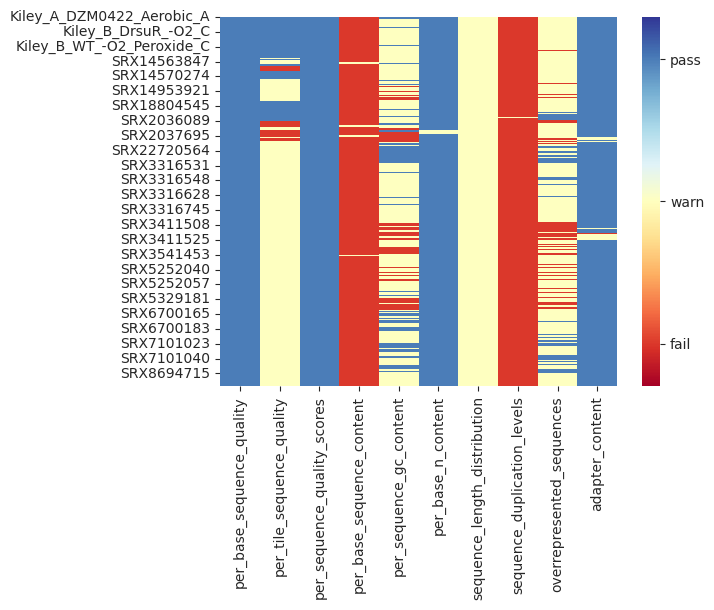

In [11]:
DF_fastqc = DF_qc_stats[fastqc_cols].replace('Conventional base calls', 'pass')
ax = sns.heatmap(DF_fastqc.replace('pass',1).replace('warn',0).replace('fail',-1),
            cmap='RdYlBu',vmax=1.3,vmin=-1.3)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-1,0,1])
cbar.set_ticklabels(['fail','warn','pass'])

The following four categories are the most important:
* per_base_sequence_quality
* per_sequence_quality_scores
* per_base_n_content
* adapter_content
    
If a sample does not pass any of these four categories, discard the sample.

In [12]:
fastqc_fail_cols = ['per_base_sequence_quality','per_sequence_quality_scores','per_base_n_content','adapter_content']

In [13]:
DF_failed_fastqc = DF_fastqc[fastqc_fail_cols][(DF_fastqc[fastqc_fail_cols] != 'pass').any(axis=1)]
DF_failed_fastqc[fastqc_fail_cols]

,per_base_sequence_quality,per_sequence_quality_scores,per_base_n_content,adapter_content
SRX2037538,pass,pass,warn,pass
SRX2037540,pass,pass,warn,pass
SRX2037541,pass,pass,warn,pass
SRX2037542,pass,pass,warn,pass
SRX2037699,pass,pass,pass,warn
SRX2037713,pass,pass,pass,warn
SRX2037715,pass,pass,pass,warn
SRX2116174,pass,pass,pass,warn
SRX2116175,pass,pass,pass,fail
SRX3411512,pass,pass,pass,warn


Mark samples that passed.

In [14]:
DF_metadata['passed_fastqc'] = ~DF_metadata.index.isin(DF_failed_fastqc.index)

### Number of aligned reads

The following histogram shows how many reads map to coding sequences (i.e. mRNA). Too few aligned reads reduces the sensitivity of the resulting data.

In [15]:
min_mrna_reads = 500000 # Minimum number of reads mapped to mRNA (500,000)

Text(0.5, 1.0, 'Number of reads mapped to CDS')

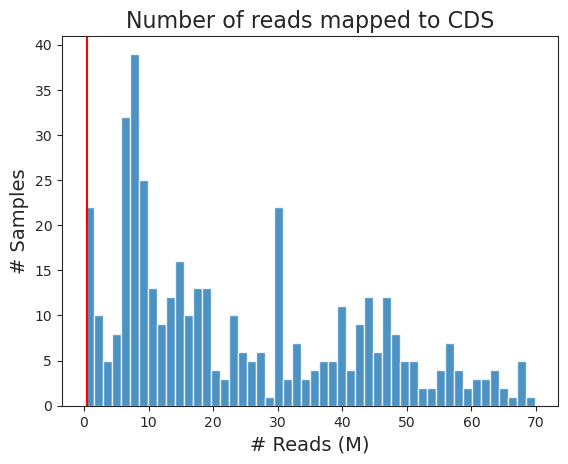

In [16]:
fig,ax = plt.subplots()
ax.hist(DF_qc_stats['Assigned']/1e6,bins=50,alpha=0.8)
ymin,ymax = ax.get_ylim()
ax.vlines(min_mrna_reads/1e6,ymin,ymax,color='r')
ax.set_ylim((ymin,ymax))
ax.set_xlabel('# Reads (M)',fontsize=14)
ax.set_ylabel('# Samples',fontsize=14)
ax.set_title('Number of reads mapped to CDS',fontsize=16)

Identify samples with poor read depth:

In [17]:
DF_failed_mrna = DF_qc_stats[DF_qc_stats['Assigned'] < min_mrna_reads].sort_values('Assigned')
DF_failed_mrna

,Unassigned_Unmapped,Unassigned_MultiMapping,percent_assigned,Unassigned_MappingQuality,Unassigned_NonSplit,Assigned,Total,Unassigned_FragmentLength,Unassigned_Duplicate,Unassigned_rRNA,...,r_written,percent_trimmed,bp_written,r_with_adapters,bp_processed,pe_sense,se_antisense,pe_antisense,failed,se_sense
Kiley_B_Dfur_-O2_B,399490,0,1.138095,0,0,97409,8558948,0,0,0,...,4281130,0.335176,619562343,1185740,621645950,0.7207,0.0,0.1990,0.0803,0.0
Kiley_B_WT_+O2_Ctrl_C,263758,0,1.276730,0,0,99822,7818566,0,0,2,...,3911176,0.319895,560503158,1139754,562301932,0.6650,0.0,0.2740,0.0611,0.0
SRX3411512,4060588,0,2.986624,0,0,249162,8342598,0,0,3979959,...,6574423,6.030947,926688459,1959672,986163450,0.0186,0.0,0.0261,0.9552,0.0
SRX3411520,4775010,0,4.326515,0,0,298926,6909164,0,0,1552409,...,3637888,9.217538,495384642,1430746,545683200,0.0821,0.0,0.1276,0.7903,0.0
SRX3411510,7241972,0,3.049755,0,0,336984,11049544,0,0,3407740,...,8069344,35.449044,781325799,4704840,1210401600,0.0267,0.0,0.0417,0.9316,0.0
SRX3411508,3148180,0,3.952659,0,0,384929,9738482,0,0,6118853,...,5873659,21.097036,695173653,3054773,881048850,0.0203,0.0,0.0255,0.9542,0.0
SRX3411511,6923670,0,2.980251,0,0,393403,13200332,0,0,5798931,...,7666246,8.434694,1052943243,3154351,1149936900,0.0222,0.0,0.0257,0.9520,0.0
SRX3411509,3873910,0,4.202683,0,0,453370,10787632,0,0,6371184,...,7911166,5.268358,1124156622,2480504,1186674900,0.0223,0.0,0.0259,0.9518,0.0
SRX3411513,5248868,0,4.423030,0,0,466297,10542478,0,0,4749202,...,7543296,34.681108,739079600,4465334,1131494400,0.0290,0.0,0.0380,0.9330,0.0


Mark samples that passed.

In [18]:
DF_metadata['passed_reads_mapped_to_CDS'] = ~DF_metadata.index.isin(DF_failed_mrna.index)

### Examine Global Correlations

Only examine data that passed the first two steps.

In [19]:
metadata_passed_step2 = DF_metadata[DF_metadata[['passed_fastqc','passed_reads_mapped_to_CDS']].all(axis=1)]
DF_log_tpm_passed_step2 = DF_log_tpm[metadata_passed_step2.index]

A clustermap is a great way to visualize the global correlations between one sample and all others. The ``global_clustering`` function uses hierarchical clustering to identify specific clusters in the clustermap. The optional arguments are:

* ``threshold``: Threshold used to extract clusters from the hierarchy. To increase the number of clusters, decrease the value of ``threshold``. To decrease the number of clusters, increase the value of ``threshold`` (default: 0.3)
* ``figsize``: A tuple describing the length and width of the final clustermap. A larger figsize can make x and y-axis labels clearer.
* ``xticklabels``: Show NCBI SRA accession numbers on the x-axis
* ``yticklabels``: Show NCBI SRA accession numbers on the y-axis

In [20]:
import scipy.cluster.hierarchy as sch
import matplotlib.patches as patches

def global_clustering(data, threshold=0.3, xticklabels=False, yticklabels=False, figsize=(9,9)):
    
    # Retrieve clusters using fcluster 
    corr = data.corr()
    corr.fillna(0,inplace=True)
    dist = sch.distance.pdist(corr)
    link = sch.linkage(dist, method='complete')
    clst = pd.DataFrame(index=data.columns)
    clst['cluster'] = sch.fcluster(link, threshold * dist.max(), 'distance')

    # Get colors for each cluster
    cm = plt.cm.get_cmap('tab20')
    cluster_colors = dict(zip(clst.cluster.unique(), cm.colors))
    clst['color'] = clst.cluster.map(cluster_colors)

    print('Number of cluster: ', len(cluster_colors))
    
    legend_items = [patches.Patch(color=c, label=l) for l,c in cluster_colors.items()]
    
    sns.set(rc={'figure.facecolor':'white'})
    
    clst_map = sns.clustermap(data.corr(), 
                              figsize=figsize, 
                              row_linkage=link, 
                              col_linkage=link, 
                              col_colors=clst.color,
                              yticklabels=yticklabels, 
                              xticklabels=xticklabels,
                              vmin=0, 
                              vmax=1)
    
    legend = clst_map.ax_heatmap.legend(loc='upper left', 
                                        bbox_to_anchor=(1.01,0.85), 
                                        handles=legend_items,
                                        frameon=True)
    
    legend.set_title(title='Clusters',prop={'size':10})
    
    return clst['cluster']

/tmp/ipykernel_26226/3866276819.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('tab20')


Number of cluster:  7


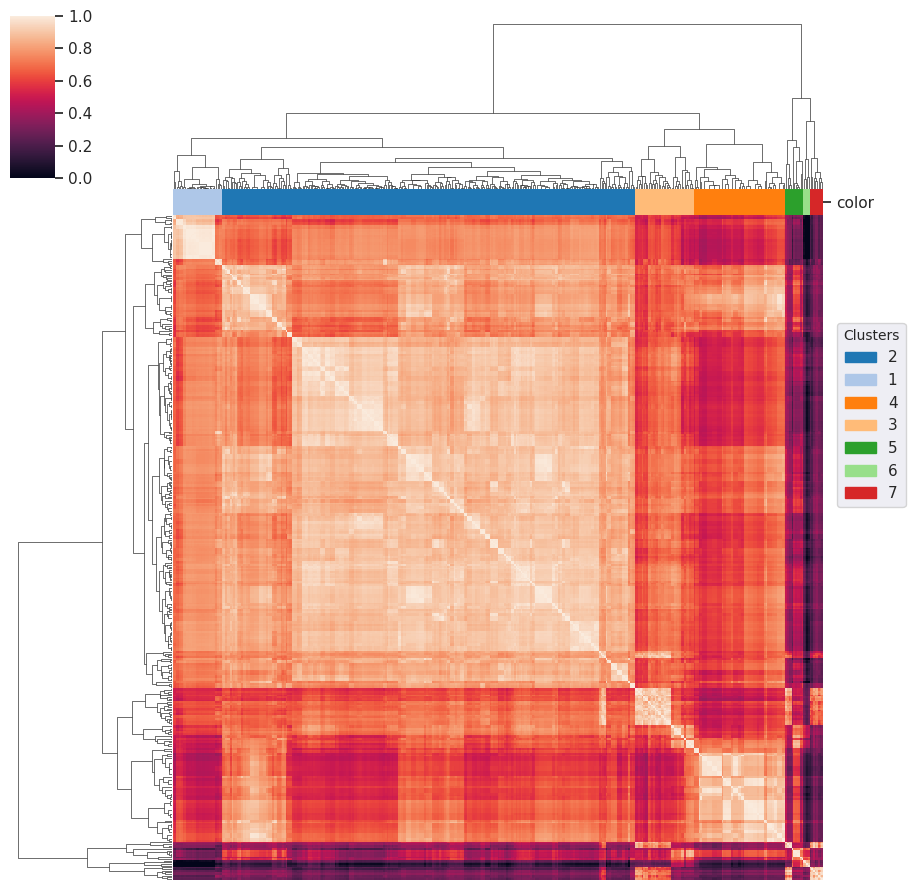

In [21]:
clusters = global_clustering(DF_log_tpm_passed_step2)

Select clusters to remove.

In [22]:
remove_clusters = []
passed_global_corr = clusters[~clusters.isin(remove_clusters)].index

The following code can be adapted to see the NCBI SRA accession for samples in each cluster.

In [23]:
clusters[clusters == 2]

Kiley_A_DZM0422_Aerobic_A      2
Kiley_A_DZM0422_Aerobic_B      2
Kiley_A_DZM0422_Aerobic_C      2
Kiley_A_DZM0422_Anaerobic_A    2
Kiley_A_DZM0422_Anaerobic_B    2
                              ..
SRX8694725                     2
SRX8694726                     2
SRX8694727                     2
SRX8694728                     2
SRX8694729                     2
Name: cluster, Length: 253, dtype: int32

Re-cluster samples to ensure all outliers were removed.

In [24]:
DF_log_tpm_passed_step3 = DF_log_tpm[passed_global_corr]

/tmp/ipykernel_26226/3866276819.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('tab20')


Number of cluster:  7


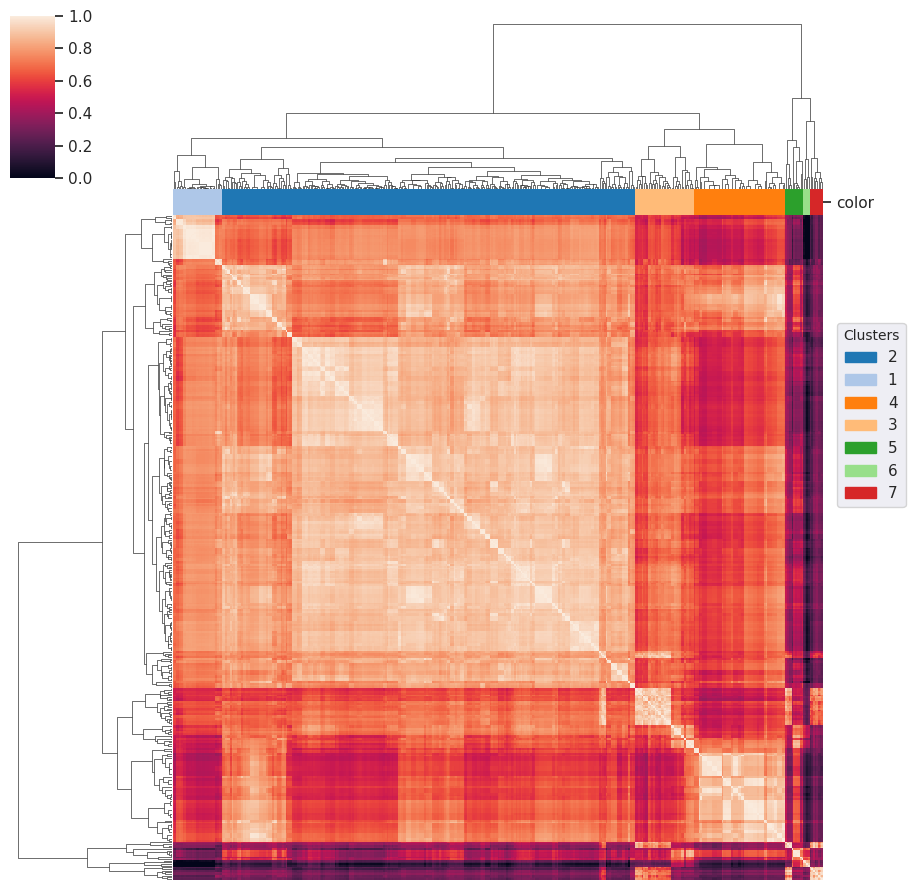

In [25]:
clusters = global_clustering(DF_log_tpm_passed_step3)

Once you are satisfied with your dataset, mark the samples that passed the global correlation

In [26]:
DF_metadata['passed_global_correlation'] = DF_metadata.index.isin(passed_global_corr)

In [27]:
DF_metadata.head()

,BioProject,additional_details_2,sample_id,study,project,condition,rep_id,doi,gene_KO,Strain Description,...,LibraryLayout,Platform,Biological Replicates,GEO,SRX,Run,run_date,passed_fastqc,passed_reads_mapped_to_CDS,passed_global_correlation
Kiley_A_DZM0422_Aerobic_A,NaN,NaN,NaN,aerobicity,aerobicity,DZM0422_Aerobic,1,NaN,NaN,Zymomonas mobilis subsp. mobilis ZM4 = ATCC 31821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True
Kiley_A_DZM0422_Aerobic_B,NaN,NaN,NaN,aerobicity,aerobicity,DZM0422_Aerobic,2,NaN,NaN,Zymomonas mobilis subsp. mobilis ZM4 = ATCC 31821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True
Kiley_A_DZM0422_Aerobic_C,NaN,NaN,NaN,aerobicity,aerobicity,DZM0422_Aerobic,3,NaN,NaN,Zymomonas mobilis subsp. mobilis ZM4 = ATCC 31821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True
Kiley_A_DZM0422_Anaerobic_A,NaN,NaN,NaN,aerobicity,aerobicity,DZM0422_Anaerobic,1,NaN,NaN,Zymomonas mobilis subsp. mobilis ZM4 = ATCC 31821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True
Kiley_A_DZM0422_Anaerobic_B,NaN,NaN,NaN,aerobicity,aerobicity,DZM0422_Anaerobic,2,NaN,NaN,Zymomonas mobilis subsp. mobilis ZM4 = ATCC 31821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True


# Remove failed samples

In [28]:
qc_columns = ['passed_fastqc',
              'passed_reads_mapped_to_CDS',
              'passed_global_correlation']

In [29]:
pass_qc = DF_metadata[qc_columns].all(axis=1)
DF_metadata_passed = DF_metadata[pass_qc]

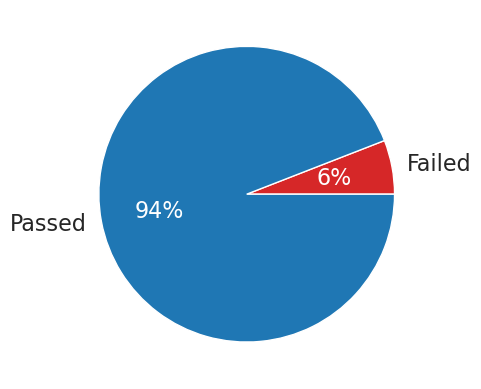

In [30]:
_,_,pcts = plt.pie(pass_qc.value_counts().reindex([False,True]),
        labels = ['Failed','Passed'],
        colors=['tab:red','tab:blue'],
        autopct='%.0f%%',textprops={'size':16});

# Colors percents white
for pct in pcts:
    pct.set_color('white')

# Save current metadata

Enter path of interim metadata files here. It is recommended that the ``metadata_qc.tsv`` file is copied to a new ``metadata_qc_curated.tsv`` file before editing. This will prevent this notebook from over-writing any curated metadata.

In [31]:
metadata_all_qc_file = path.join('..', 'data', 'interim', 'metadata_qc_part1_all.tsv') # Enter filename for full metadata QC file
metadata_qc_file = path.join('..', 'data', 'interim', 'metadata_qc_part1_curated.tsv') # Enter filename for metadata QC file with only passing datasets

In [32]:
DF_metadata.to_csv(metadata_all_qc_file, sep='\t')
DF_metadata_passed.to_csv(metadata_qc_file, sep='\t')

# Metadata Curation

The next step is to curate the metadata. At a minimum, three new columns must be added to the metadata sheet:
* ``project``: Nickname for the project. Each bioproject should have a unique project IDs.
* ``condition``: Nickname for the experimental condition. Biological/technical replicates must have identical condition IDs.
* ``reference_condition``: Condition ID of the reference condition. Each project has a single reference condition (See [example metadata sheet](https://github.com/SBRG/nf-rnaseq-bacteria/blob/master/example_data/processed_data/metadata_curated.tsv))

Additional columns may include:
* ``strain_description``: The strain name, and any knock-outs or overexpressed genes
* ``base_media``: Media used (e.g. ``M9``)
* ``carbon_source``: Primary carbon source, with concentration in parentheses (e.g. ``glucose(.4%)``). This is usually empty for undefined media.
* ``nitrogen_source``: Primary nitrogen source, with concentration in parentheses (e.g. ``NH4Cl(1M)``). This is usually empty for undefined media.
* ``aerobicity``: Usually ``aerobic`` or ``anaerobic``
* ``treatment``: Any additional supplements or treatments added to the base media (e.g. ``thiamine(0.1M)`` or ``ampicillin(100ug/mL)``)
* ``temperature``
* ``pH``
* ``OD``: Approximate optical density of cells when selected for library preparation
* ``growth_phase``: e.g. ``mid-exponential`` or ``stationary``
* ``culture_type``: Usually ``batch`` or ``chemostat``
* ``skip``: Whether to skip a sample due to external reasons (e.g. not traditional RNA-seq, distant strain, or lack of metadata)

If specific metadata entries are not reported for a sample, these can be left blank. However, if no metadata can be gleaned from public databases, then we recommend discarding the samples.

Once the metadata has been curated, proceed to [Step 2](https://github.com/avsastry/modulome-workflow/edit/main/3_quality_control/expression_QC_part2.ipynb)